## インポート宣言

In [1]:
%matplotlib inline

import os, cv2
import matplotlib.pyplot as plt
import numpy as np

from keras.datasets import mnist
from keras.layers import Activation, BatchNormalization, Dense, Dropout, Flatten, Reshape
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.models import Sequential
from keras.optimizers import Adam

Using TensorFlow backend.


### 猫の正解画像の読み込み

In [2]:
TRAIN_DIR = '../dogvscats/input/train/'
train_cats =   [TRAIN_DIR+i for i in os.listdir(TRAIN_DIR) if 'cat' in i]

# 28ドット×28ドット×1チャンネル
img_rows = 28
img_cols = 28
channels = 1

def read_image(file_path):
    # ファイルの読み込み
    img = cv2.imread(file_path, 0)
    # 28*28に画像をリサイズ
    return cv2.resize(img, (img_rows, img_cols), interpolation=cv2.INTER_CUBIC)

def prep_data(images):
    count = len(images)
    data = np.ndarray((count, img_rows, img_cols, channels), dtype=np.uint8)

    for i, image_file in enumerate(images):
        image = read_image(image_file)
        # 配列の拡張（n,28,28)→(n,28,28,1)
        data[i] = np.expand_dims(image, axis=2)
        if i%250 == 0: print('Processed {} of {}'.format(i, count))
    
    return data

train = prep_data(train_cats)

Processed 0 of 12500
Processed 250 of 12500
Processed 500 of 12500
Processed 750 of 12500
Processed 1000 of 12500
Processed 1250 of 12500
Processed 1500 of 12500
Processed 1750 of 12500
Processed 2000 of 12500
Processed 2250 of 12500
Processed 2500 of 12500
Processed 2750 of 12500
Processed 3000 of 12500
Processed 3250 of 12500
Processed 3500 of 12500
Processed 3750 of 12500
Processed 4000 of 12500
Processed 4250 of 12500
Processed 4500 of 12500
Processed 4750 of 12500
Processed 5000 of 12500
Processed 5250 of 12500
Processed 5500 of 12500
Processed 5750 of 12500
Processed 6000 of 12500
Processed 6250 of 12500
Processed 6500 of 12500
Processed 6750 of 12500
Processed 7000 of 12500
Processed 7250 of 12500
Processed 7500 of 12500
Processed 7750 of 12500
Processed 8000 of 12500
Processed 8250 of 12500
Processed 8500 of 12500
Processed 8750 of 12500
Processed 9000 of 12500
Processed 9250 of 12500
Processed 9500 of 12500
Processed 9750 of 12500
Processed 10000 of 12500
Processed 10250 of 12

## モデルの入力次元

In [3]:
# 28ドット×28ドット×1チャンネル
img_rows = 28
img_cols = 28
channels = 1

# 入力画像の次元
img_shape = (img_rows, img_cols, channels)

# 生成器の入力として使用されるノイズベクトルの次元（100個）
z_dim = 100

## 生成器

In [4]:
def build_generator(z_dim):

    model = Sequential()

    # 全結合によって、7*7*256のテンソルに変換
    model.add(Dense(256 * 7 * 7, input_dim=z_dim))
    model.add(Reshape((7, 7, 256)))

    # 転置畳み込み層により、7*7*256を14*14*128のテンソルに変換
    model.add(Conv2DTranspose(128, kernel_size=3, strides=2, padding='same'))

    # バッチ正規化
    model.add(BatchNormalization())

    # 活性化関数（Leaky ReLU）
    model.add(LeakyReLU(alpha=0.01))

    # 転置畳み込み層により、14*14*128を14*14*64のテンソルに変換
    model.add(Conv2DTranspose(64, kernel_size=3, strides=1, padding='same'))

    # バッチ正規化
    model.add(BatchNormalization())

    # 活性化関数（Leaky ReLU）
    model.add(LeakyReLU(alpha=0.01))

    # 転置畳み込み層により、14*14*64を28*28*1のテンソルに変換
    model.add(Conv2DTranspose(1, kernel_size=3, strides=2, padding='same'))

    # 活性化関数（tanh）
    model.add(Activation('tanh'))

    return model

## 識別器

In [5]:
def build_discriminator(img_shape):

    model = Sequential()

    # 28*28*1を14*14*32のテンソルにする畳み込み層
    model.add(
        Conv2D(32,
               kernel_size=3,
               strides=2,
               input_shape=img_shape,
               padding='same'))

    # 活性化関数（Leaky ReLU）
    model.add(LeakyReLU(alpha=0.01))

    # 14*14*32を7*7*64のテンソルにする畳み込み層
    model.add(
        Conv2D(64,
               kernel_size=3,
               strides=2,
               input_shape=img_shape,
               padding='same'))

    # バッチ正規化
    model.add(BatchNormalization())

    # 活性化関数（Leaky ReLU）
    model.add(LeakyReLU(alpha=0.01))

    # 7*7*64を3*3*128のテンソルにする畳み込み層
    model.add(
        Conv2D(128,
               kernel_size=3,
               strides=2,
               input_shape=img_shape,
               padding='same'))

    # バッチ正規化
    model.add(BatchNormalization())

    # 活性化関数（Leaky ReLU）
    model.add(LeakyReLU(alpha=0.01))

    # 出力層（sigmoid）
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))

    return model

## GANの構築

In [6]:
def build_gan(generator, discriminator):

    model = Sequential()

    # 生成器と識別器の統合
    model.add(generator)
    model.add(discriminator)

    return model

## コンパイル

In [7]:
# 識別器の構築とコンパイル
discriminator = build_discriminator(img_shape)
discriminator.compile(loss='binary_crossentropy',
                      optimizer=Adam(),
                      metrics=['accuracy'])

# 生成器の構築
generator = build_generator(z_dim)

# 生成器の構築中は識別器のパラメータを固定（識別器は学習しない）
discriminator.trainable = False

# 生成器の訓練の為、識別器は固定し、GANモデルの構築とコンパイル
gan = build_gan(generator, discriminator)
gan.compile(loss='binary_crossentropy', 
            optimizer=Adam())

## 画像を表示する関数定義

In [8]:
def sample_images(generator, image_grid_rows=4, image_grid_columns=4):

    # ランダムノイズのサンプリングを生成
    z = np.random.normal(0, 1, (image_grid_rows * image_grid_columns, z_dim))

    # ランダムノイズを使用して生成器で画像を作る（学習中）
    gen_imgs = generator.predict(z)

    # 画像の画素値を[0,1]の範囲にスケールする
    gen_imgs = 0.5 * gen_imgs + 0.5

    # 画像をグリッドに並べる
    fig, axs = plt.subplots(image_grid_rows,
                            image_grid_columns,
                            figsize=(4, 4),
                            sharey=True,
                            sharex=True)

    cnt = 0
    for i in range(image_grid_rows):
        for j in range(image_grid_columns):
            # 画像描画
            axs[i, j].imshow(gen_imgs[cnt, :, :, 0], cmap='gray')
            axs[i, j].axis('off')
            cnt += 1

## 学習

1000 [D loss: 0.043810, acc.: 99.61%] [G loss: 5.439199]
2000 [D loss: 0.062324, acc.: 99.61%] [G loss: 5.285698]
3000 [D loss: 0.223203, acc.: 89.45%] [G loss: 4.129907]
4000 [D loss: 0.064404, acc.: 99.22%] [G loss: 4.866313]
5000 [D loss: 0.068711, acc.: 98.83%] [G loss: 3.845239]
6000 [D loss: 0.088137, acc.: 98.44%] [G loss: 4.303262]
7000 [D loss: 0.067385, acc.: 98.05%] [G loss: 3.774468]
8000 [D loss: 0.035001, acc.: 99.61%] [G loss: 4.314431]
9000 [D loss: 0.029773, acc.: 100.00%] [G loss: 5.856422]
10000 [D loss: 0.045387, acc.: 99.61%] [G loss: 4.857150]
11000 [D loss: 0.018732, acc.: 100.00%] [G loss: 5.763033]
12000 [D loss: 0.014895, acc.: 100.00%] [G loss: 5.955620]
13000 [D loss: 0.340344, acc.: 83.20%] [G loss: 3.513106]
14000 [D loss: 0.009715, acc.: 100.00%] [G loss: 6.246099]
15000 [D loss: 0.142180, acc.: 94.92%] [G loss: 3.378285]
16000 [D loss: 0.122629, acc.: 94.53%] [G loss: 5.290255]
17000 [D loss: 0.070753, acc.: 97.66%] [G loss: 6.163090]
18000 [D loss: 0.16

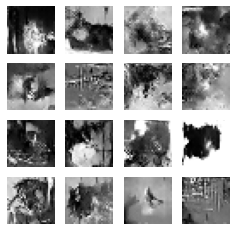

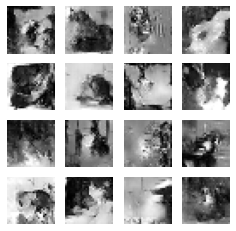

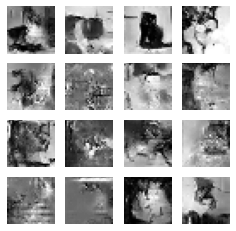

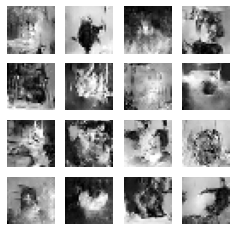

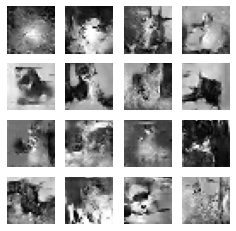

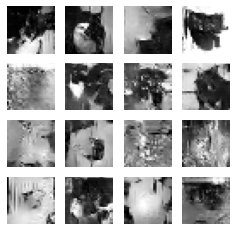

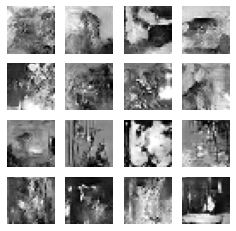

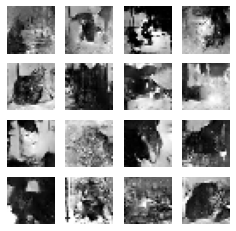

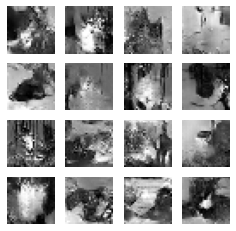

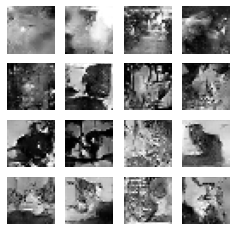

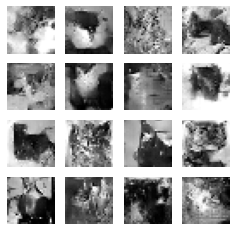

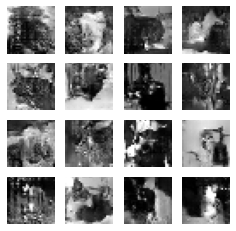

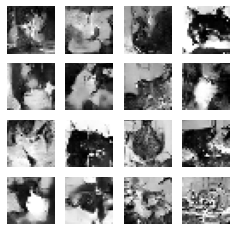

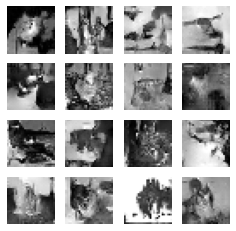

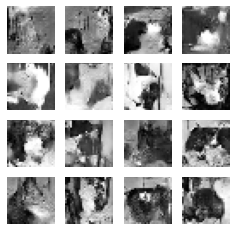

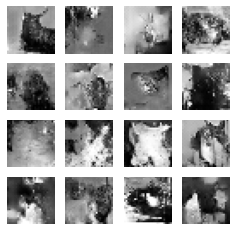

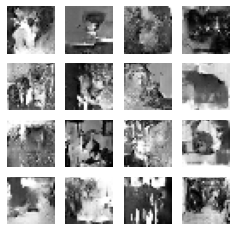

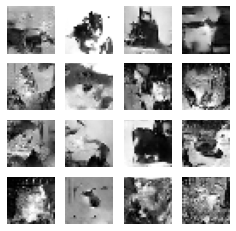

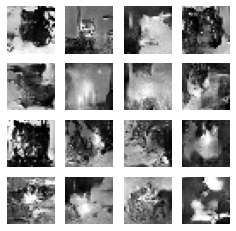

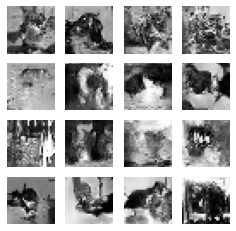

In [11]:
# 結果を保存する為の配列定義
losses = []
accuracies = []
iteration_checkpoints = []

# 20000回の学習、バッチサイズ（128）、1000回毎に結果を表示
iterations = 20000
batch_size = 128
sample_interval = 1000

# MNISTデータセットをロード
#(X_train, _), (_, _) = mnist.load_data()
X_train = train

# [0,255]の範囲のグレースケール画素値を[-1,1]にスケーリング
X_train = X_train / 127.5 - 1.0
# (60000,28,28)→(60000,28,28,1)
#X_train = np.expand_dims(X_train, axis=3)

# 本物の画像のラベルはすべて１とする
real = np.ones((batch_size, 1))

# 偽の画像のレベルはすべて０とする
fake = np.zeros((batch_size, 1))

# 20000回の学習
for iteration in range(iterations):

    # -------------------------
    #  識別器の学習
    # -------------------------

    # 本物の画像をランダムに取り出したバッチを作る
    idx = np.random.randint(0, X_train.shape[0], batch_size)
    imgs = X_train[idx]

    # 偽の画像を生成器で作成してバッチを作る
    z = np.random.normal(0, 1, (batch_size, 100))
    gen_imgs = generator.predict(z)

    # 識別器の学習（独自ループで学習する場合は、fitではなくtrain_on_batchを使用する）
    # 本物で学習
    d_loss_real = discriminator.train_on_batch(imgs, real)
    # 偽物で学習
    d_loss_fake = discriminator.train_on_batch(gen_imgs, fake)
    # ２つの成績の平均
    d_loss, accuracy = 0.5 * np.add(d_loss_real, d_loss_fake)

    # ---------------------
    #  生成器の学習
    # ---------------------

    # 偽の画像を生成器で作成してバッチを作る
    z = np.random.normal(0, 1, (batch_size, 100))
    # 生成器の学習（識別器のパラメータは固定）
    # 識別器が本物と認識するように学習を行う
    g_loss = gan.train_on_batch(z, real)

    # 1000回毎に結果を記録する
    if (iteration + 1) % sample_interval == 0:
        losses.append((d_loss, g_loss))
        accuracies.append(100.0 * accuracy)
        iteration_checkpoints.append(iteration + 1)
        print("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" %
                  (iteration + 1, d_loss, 100.0 * accuracy, g_loss))
        sample_images(generator)

## 一つだけ画像を生成器で作ってみる

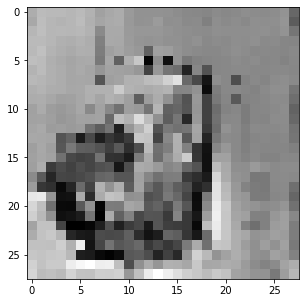

In [14]:
# ランダムノイズ
z = np.random.normal(0, 1, (1, 100))
#　学習済みの生成器で画像を作る
gen_imgs = generator.predict(z)
gen_imgs = 0.5 * gen_imgs + 0.5

# 画像描画
fig, axs = plt.subplots(1,
                        1,
                        figsize=(5, 5),
                        sharey=True,
                        sharex=True)
axs.imshow(gen_imgs[0, :, :, 0], cmap='gray')


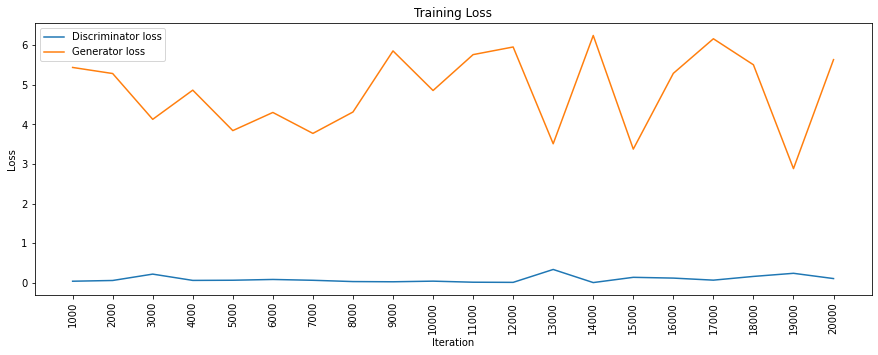

In [15]:
losses = np.array(losses)

# Plot training losses for Discriminator and Generator
plt.figure(figsize=(15, 5))
plt.plot(iteration_checkpoints, losses.T[0], label="Discriminator loss")
plt.plot(iteration_checkpoints, losses.T[1], label="Generator loss")

plt.xticks(iteration_checkpoints, rotation=90)

plt.title("Training Loss")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.legend()

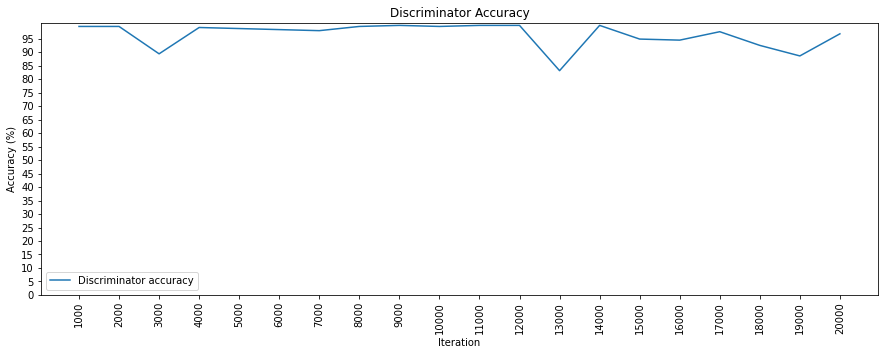

In [16]:
accuracies = np.array(accuracies)

# Plot Discriminator accuracy
plt.figure(figsize=(15, 5))
plt.plot(iteration_checkpoints, accuracies, label="Discriminator accuracy")

plt.xticks(iteration_checkpoints, rotation=90)
plt.yticks(range(0, 100, 5))

plt.title("Discriminator Accuracy")
plt.xlabel("Iteration")
plt.ylabel("Accuracy (%)")
plt.legend()